In [1]:
from __future__ import annotations

import itertools
from typing import TYPE_CHECKING, Any

from lsst.afw.geom import makeSkyWcs, SkyWcs
from lsst.afw.cameraGeom import Detector, FIELD_ANGLE, PIXELS
from lsst.geom import Angle, Point2D, SpherePoint, degrees
from lsst.obs.base.utils import createInitialSkyWcsFromBoresight
from lsst.sphgeom import ConvexPolygon
import matplotlib as mpl
from matplotlib import pyplot

from lsst.daf.butler import Butler
from lsst.afw.table import ExposureCatalog, SchemaMapper
from importlib import reload
from tqdm.notebook import tqdm
import astropy.table
import astropy.units as u
import numpy as np

if TYPE_CHECKING:
    from matplotlib.axes import Axes
    from matplotlib.figure import Figure


In [2]:
w45 = "LSSTCam/runs/DRP/20250421_20250921/d_2025_11_10/DM-53195"
dev = "u/jbosch/DM-51297/w45/d"
butler = Butler("dp2_prep", collections=w45, skymap="lsst_cells_v2")

In [3]:
refs = butler.query_datasets("visit_summary", collections=dev, limit=None)

In [4]:
def build_table(refs, butler):
    visit_tables = []
    for ref in tqdm(refs):
        visit_summary = butler.get(ref)
        visit_table = visit_summary.asAstropy(copy=True)
        visit_table.meta.clear()
        visit_table["visit"] = [ref.dataId["visit"]] * len(visit_summary)
        visit_tables.append(visit_table)

    return astropy.table.vstack(visit_tables, join_type="exact")


table = build_table(refs, butler)

  0%|          | 0/4536 [00:00<?, ?it/s]

In [5]:
from lsst.daf.butler.formatters.parquet import astropy_to_arrow
import pyarrow.parquet as pq

pq.write_table(astropy_to_arrow(table), "visit_summary-d.parq")

In [6]:
table.rename_column("id", "detector")

In [7]:
c = "wcs_visit_pointing_residual"
by_visit = table[
    "visit", "detector", c, "wcs_detector_pointing_residual", "wcs_detector_pointing_rejected"
].group_by("visit")

In [8]:
visit_max_residuals = by_visit["visit", c].groups.aggregate(np.nanmax)
visit_argsort = np.argsort(visit_max_residuals[c])
visit_rank = np.argsort(visit_argsort)

full_rank = np.zeros(len(by_visit), dtype=int)
for r, (a, b) in zip(visit_rank, itertools.pairwise(by_visit.groups.indices)):
    full_rank[a:b] = r

In [9]:
%matplotlib widget

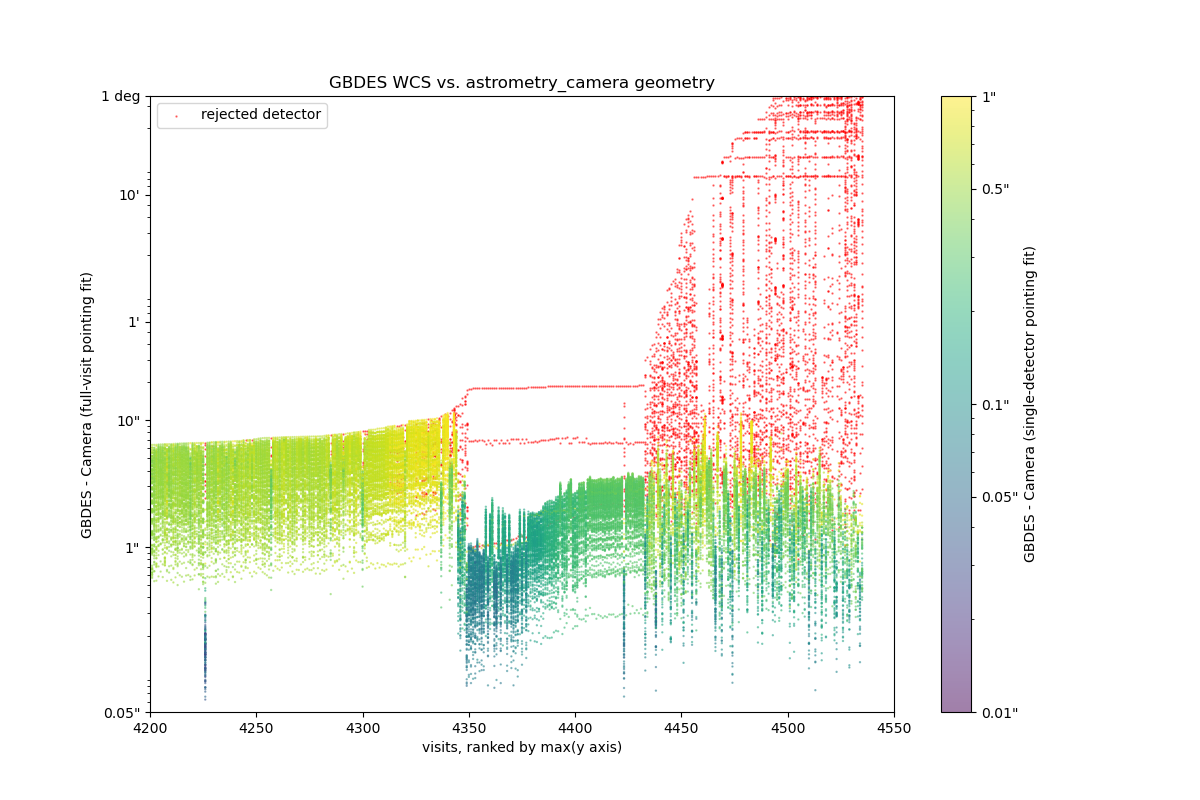

In [60]:
rej = by_visit["wcs_detector_pointing_rejected"]
kept = np.logical_not(rej)
figure = pyplot.figure(figsize=(12, 8))
axes = figure.add_subplot()
px = full_rank
py = by_visit[c].to(u.arcsec)
pc = by_visit["wcs_detector_pointing_residual"].to(u.arcsec)
axes.scatter(px[rej], py[rej], s=0.5, alpha=0.5, c="red", label="rejected detector")
mappable = axes.scatter(px[kept], py[kept], c=pc[kept].value, s=0.5, alpha=0.5, norm="log", vmin=0.01, vmax=1.0)
axes.semilogy()
axes.set_ylim(0.05, 3600.0)
axes.set_yticks([0.05, 1.0, 10.0, 60.0, 600.0, 3600.0], labels=['0.05"', '1"', '10"', "1'", "10'", "1 deg"])
# axes.set_ylim(0.05, 60.0)
# axes.set_yticks([0.05, 1.0, 10.0, 60.0], labels=['0.05"', '1"', '10"', "1'"])
axes.set_xlim(4200, 4550)
axes.set_xlabel("visits, ranked by max(y axis)")
axes.set_ylabel("GBDES - Camera (full-visit pointing fit)")
axes.set_title("GBDES WCS vs. astrometry_camera geometry")
axes.legend()
cbar = figure.colorbar(mappable, ax=axes)
cbar.set_ticks([0.01, 0.05, 0.1, 0.5, 1.0], labels=['0.01"', '0.05"', '0.1"', '0.5"', '1"'])
cbar.set_label("GBDES - Camera (single-detector pointing fit)")

In [ ]:
import logging

reload(logging)
from lsst.utils.logging import VERBOSE

logging.basicConfig(level=VERBOSE)

In [73]:
visit = int(by_visit.groups.keys[visit_argsort[4535]]["visit"])
visit

2025071100816

In [74]:
# visit = 2025091900191
# visit = 2025052300137


In [75]:
input_schema = butler.get("visit_summary_schema").schema

In [76]:
input_summary = butler.get("visit_summary", visit=visit)

In [77]:
# camera = butler.get("camera", visit=visit)
camera = butler.get("astrometry_camera", visit=visit)

In [78]:
import lsst.meas.astrom.refit_pointing

reload(lsst.meas.astrom.refit_pointing)
RefitPointingTask = lsst.meas.astrom.refit_pointing.RefitPointingTask

In [79]:
mapper = SchemaMapper(input_schema)
mapper.addMinimalSchema(input_schema, True)
schema = mapper.getOutputSchema()
config = RefitPointingTask.ConfigClass()
task = RefitPointingTask(config=config, schema=schema)

In [80]:
catalog = ExposureCatalog(schema)
catalog.extend(input_summary, mapper=mapper)

In [81]:
result = task.run(catalog=catalog, camera=camera)

In [82]:
from __future__ import annotations

from typing import TYPE_CHECKING, Any

from lsst.afw.geom import makeSkyWcs, SkyWcs
from lsst.afw.cameraGeom import Detector, FIELD_ANGLE, PIXELS
from lsst.geom import Angle, Point2D, SpherePoint, degrees
from lsst.obs.base.utils import createInitialSkyWcsFromBoresight
from lsst.sphgeom import ConvexPolygon
import matplotlib as mpl

if TYPE_CHECKING:
    from matplotlib.axes import Axes
    from matplotlib.figure import Figure


def plot_visit(
    result,
    camera,
    axes: Axes | None = None,
    figure: Figure | None = None,
    proj: SkyWcs | None = None,
    figure_kwargs: dict[str, Any] | None = None,
    fit_region_style: dict[str, Any] | None = None,
    raw_region_style: dict[str, Any] | None = None,
    fallback_region_style: dict[str, Any] | None = None,
    plot_all_fallback: bool = False,
) -> tuple[Axes, SkyWcs]:
    if axes is None:
        if proj is None:
            proj = makeSkyWcs(Point2D(0.0, 0.0), result.boresight, np.identity(2))
        if figure is None:
            from lsst.utils.plotting import make_figure

            figure = make_figure(**(figure_kwargs or {}))
        axes = figure.add_subplot()
        axes.set_title(f"visit={visit}")
        axes.set_xlabel("local right ascension (deg)")
        axes.set_ylabel("local declination (deg)")
    elif proj is None:
        raise TypeError("proj must be provided if axes is provided.")
    if fallback_region_style is not None:
        fallback_region_style["label"] = "refit pointing + camera geom"
        fallback_wcs: SkyWcs | None = None
        detector: Detector
        for detector in camera:
            record = result.catalog.find(detector.getId())
            has_fit_wcs = record is not None and record.getWcs() is not None
            if plot_all_fallback or not has_fit_wcs:
                fallback_wcs = result.fallbacks[detector.getId()]
                corners = fallback_wcs.pixelToSky(detector.getCorners(PIXELS))
                _plot_polygon(
                    axes,
                    proj,
                    ConvexPolygon([sp.getVector() for sp in corners]),
                    **fallback_region_style,
                )
                fallback_region_style.pop("label", None)
    raw_wcs = None
    if fit_region_style is not None:
        norm = mpl.colors.LogNorm(vmin=0.1, vmax=60)
        cmap = mpl.colormaps["cividis"]
        fit_region_style["label"] = "GBDES"
        for record in result.catalog:
            fit_wcs = record.getWcs()
            if fit_wcs is not None:
                try:
                    detector = camera[record.getId()]
                except LookupError:
                    continue
                corners = fit_wcs.pixelToSky(detector.getCorners(PIXELS))
                if record["wcs_detector_pointing_rejected"]:
                    hatch = "XX"
                else:
                    hatch = None
                _plot_polygon(
                    axes,
                    proj,
                    ConvexPolygon([sp.getVector() for sp in corners]),
                    facecolor=cmap(norm(record["wcs_visit_pointing_residual"].asArcseconds())),
                    **fit_region_style,
                    hatch=hatch,
                )
                fit_region_style.pop("label", None)
        if figure is not None:
            cbar = figure.colorbar(
                mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax=axes,
                alpha=fit_region_style.get("alpha", 1.0),
            )
            cbar.set_label("wcs_visit_pointing_residual (arcsec)")
    if raw_region_style is not None:
        raw_region_style["label"] = "raw pointing + camera geom"
        visit_info = catalog[0].getVisitInfo()
        for detector in camera:
            raw_wcs = createInitialSkyWcsFromBoresight(
                visit_info.getBoresightRaDec(),
                visit_info.getBoresightRotAngle(),
                detector=detector,
            )
            detector = camera[detector.getId()]
            corners = raw_wcs.pixelToSky(detector.getCorners(PIXELS))
            _plot_polygon(axes, proj, ConvexPolygon([sp.getVector() for sp in corners]), **raw_region_style)
            raw_region_style.pop("label", None)
    axes.axis("equal")
    return axes, proj


def _plot_polygon(
    axes: Axes,
    proj: SkyWcs,
    polygon: ConvexPolygon,
    **style: Any,
) -> None:
    vertices = np.array(proj.skyToPixel([SpherePoint(v) for v in polygon.getVertices()]))
    axes.fill(vertices[:, 0], vertices[:, 1], **style)


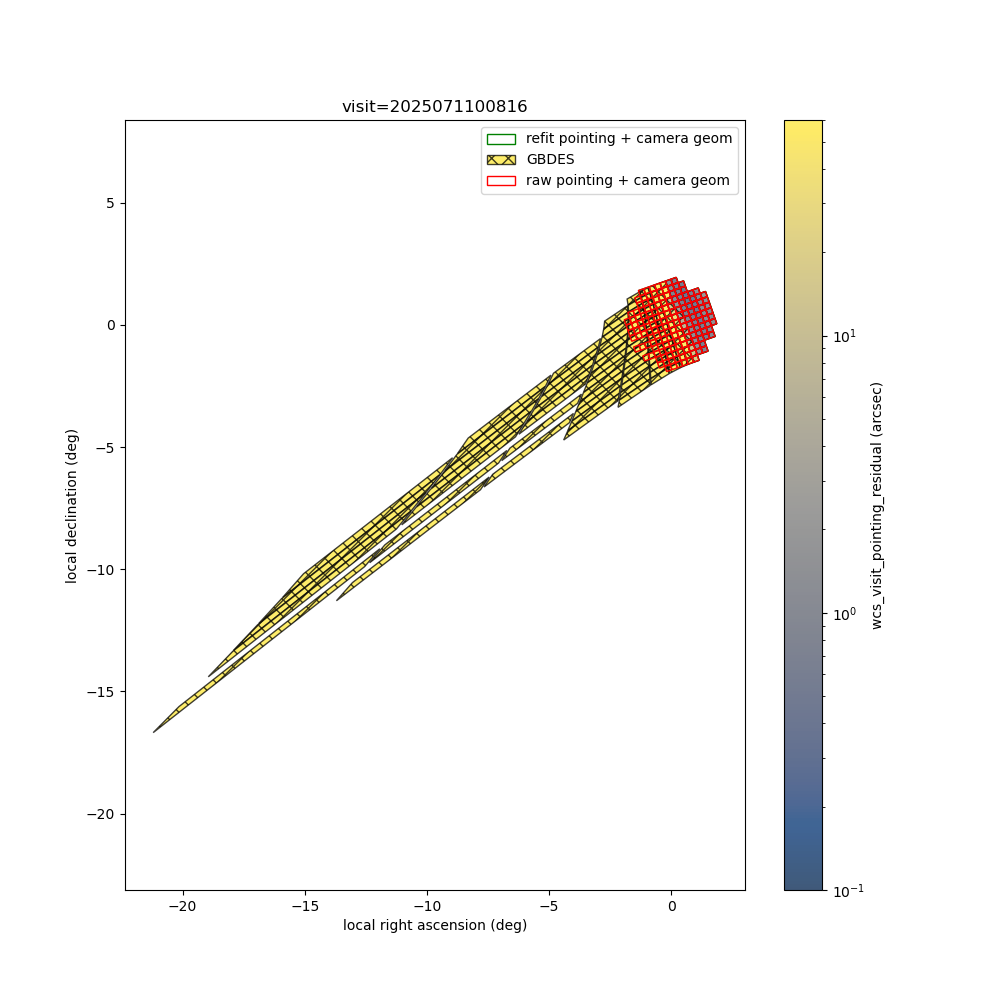

In [83]:
from matplotlib import pyplot

figure = pyplot.figure(figsize=(10, 10))

axes, proj = plot_visit(
    result,
    camera,
    figure=figure,
    fit_region_style=dict(fill=True, edgecolor="k", alpha=0.75),
    raw_region_style=dict(fill=False, edgecolor="r"),
    fallback_region_style=dict(fill=False, edgecolor="g"),
    plot_all_fallback=True,
)
axes.legend()

In [106]:
cm = mpl.colormaps["cividis"]

In [ ]:
norm = mpl.colors.LogNorm(vmin=1e-3, vmax=3600)

In [72]:
visit

2025091900249